In [1]:
import cymetric as cym
import pandas as pd

import numpy as np
import sklearn as skl
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (40,24)
from cymetric import graphs as cgr
from cymetric import timeseries as tm
from cymetric import filters as fl

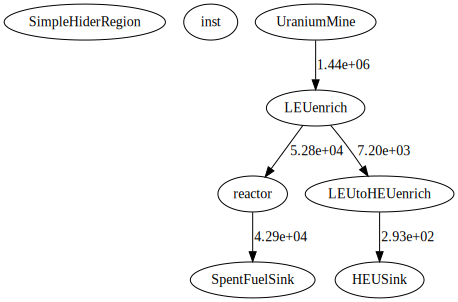

In [2]:
file = "0309base.sqlite"
db = cym.dbopen(file)
ev = cym.Evaluator(db=db, write=True)
cym.graphs.flow_graph(ev, label = "mass")

#### extract data from the sqlite file

In [3]:
agentTable = ev.eval("AgentEntry")
#print(type(agentTable))
#print(agentTable)
agents = agentTable.loc[:, ["AgentId", "Prototype"]]
print(agents)

transTable = ev.eval("Transactions")
transactions = transTable.loc[:, ["SenderId", "ReceiverId", "ResourceId", "Commodity", "Time"]]
print(transactions)
print (transactions['ReceiverId'].unique())
    
resourceTable = ev.eval("Resources")
resources = resourceTable.loc[:, ["ResourceId", "Quantity"]]
print(resources)

   AgentId          Prototype
0       14  SimpleHiderRegion
1       15               inst
2       16        UraniumMine
3       17          LEUenrich
4       18            reactor
5       19      SpentFuelSink
6       20     LEUtoHEUenrich
7       21            HEUSink
     SenderId  ReceiverId  ResourceId Commodity  Time
0          16          17          11    c_uore     0
1          16          17          26    c_uore     1
2          17          20          32     c_leu     1
3          20          21          49     c_heu     2
4          16          17          51    c_uore     2
..        ...         ...         ...       ...   ...
311        17          20        2233     c_leu   141
312        20          21        2243     c_heu   142
313        16          17        2245    c_uore   142
314        16          17        2256    c_uore   143
315        17          20        2262     c_leu   143

[316 rows x 5 columns]
[17 20 21 18 19]
     ResourceId       Quantity
0         

In [4]:
def tidy_df(file):
    db = cym.dbopen(file)
    ev = cym.Evaluator(db=db, write=True)
    
    agentTable = ev.eval("AgentEntry")
    agents = agentTable.loc[:, ["AgentId", "Prototype"]]
    
    transTable = ev.eval("Transactions")
    transactions = transTable.loc[:, ["SenderId", "ReceiverId", "ResourceId", "Commodity", "Time"]]
    
    resourceTable = ev.eval("Resources")
    resources = resourceTable.loc[:, ["ResourceId", "Quantity"]]
    
    #merge agents, transactions, and resources
    int1 = pd.merge(transactions, resources, on='ResourceId', how='inner')

    #rename AgentId column to facilitate merge 
    send = agents.rename(columns = {"AgentId": "SenderId"})
    receive = agents.rename(columns = {"AgentId": "ReceiverId"})

    for i in range(len(int1)):
        for j in range(len(send)):
            if int1.loc[i,"SenderId"] == send.loc[j, "SenderId"]:
                int1.loc[i,"SenderId"] = send.loc[j, "Prototype"]
                
    for i in range(len(int1)):
        for j in range(len(receive)):
            if int1.loc[i,"ReceiverId"] == receive.loc[j, "ReceiverId"]:
                int1.loc[i,"ReceiverId"] = receive.loc[j, "Prototype"]

    
    return int1
    

In [5]:
tidy_data = tidy_df("0309base.sqlite")
tidy_data

,SenderId,ReceiverId,ResourceId,Commodity,Time,Quantity
0,UraniumMine,LEUenrich,11,c_uore,0,10000.000000
1,UraniumMine,LEUenrich,26,c_uore,1,10000.000000
2,LEUenrich,LEUtoHEUenrich,32,c_leu,1,100.000000
3,LEUtoHEUenrich,HEUSink,49,c_heu,2,4.124861
4,UraniumMine,LEUenrich,51,c_uore,2,10000.000000
5,UraniumMine,LEUenrich,67,c_uore,3,10000.000000
6,LEUenrich,LEUtoHEUenrich,73,c_leu,3,100.000000
7,LEUtoHEUenrich,HEUSink,90,c_heu,4,4.124861
8,UraniumMine,LEUenrich,92,c_uore,4,10000.000000
9,LEUenrich,reactor,98,c_leu,4,3300.000000


#### trim resource-identifying columns

In [19]:
trimmed = tidy_data[["SenderId", "ReceiverId", "Time", "Quantity"]]
#trimmed
trimmed["fraction"] = pd.Series(0, index = range(316))
trimmed["truck"] = pd.Series(0, index = range(316))

#assume leu and heu enrichment happens in the same physical facility
#drop rows with transactions between enrichment facilities

short = trimmed.loc[(trimmed['SenderId'] != "LEUenrich") & (trimmed['ReceiverId'] != "LEUtoHEUenrich")]
#short

#change the name of enrichment facilites 
short["SenderId"] = short['SenderId'].replace({'LEUenrich': 'enrichment', 'LEUtoHEUenrich': 'enrichment'})
short['ReceiverId'] = short['ReceiverId'].replace({'LEUenrich': 'enrichment', 'LEUtoHEUenrich': 'enrichment'})
short

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_l

,SenderId,ReceiverId,Time,Quantity,fraction,truck
0,UraniumMine,enrichment,0,10000.000000,0,0
1,UraniumMine,enrichment,1,10000.000000,0,0
3,enrichment,HEUSink,2,4.124861,0,0
4,UraniumMine,enrichment,2,10000.000000,0,0
5,UraniumMine,enrichment,3,10000.000000,0,0
7,enrichment,HEUSink,4,4.124861,0,0
8,UraniumMine,enrichment,4,10000.000000,0,0
10,UraniumMine,enrichment,5,10000.000000,0,0
12,enrichment,HEUSink,6,4.124861,0,0
13,UraniumMine,enrichment,6,10000.000000,0,0


#### define truck

for each transaction, cap shipment at a certain mass m ( = 25000kg? )
create a new column with the number of trucks sent for this interaction (0 + )
consider storing heu for several timesteps


In [20]:
short["fraction"] = short["Quantity"] / 25000
print(short.head())

      SenderId  ReceiverId  Time      Quantity  fraction  truck
0  UraniumMine  enrichment     0  10000.000000  0.400000      0
1  UraniumMine  enrichment     1  10000.000000  0.400000      0
3   enrichment     HEUSink     2      4.124861  0.000165      0
4  UraniumMine  enrichment     2  10000.000000  0.400000      0
5  UraniumMine  enrichment     3  10000.000000  0.400000      0


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
MtoE = 0
EtoSink = 0
EtoR = 0
RtoSink = 0
for index, row in short.iterrows(): 
    if row["SenderId"] == "UraniumMine" and row["ReceiverId"] == "enrichment":
        print("yes")
        MtoE += row["fraction"]
        if MtoE > 1:
            row["truck"] = 1
            MtoE = 0
    if row.SenderId == "enrichment" and row.ReceiverId == "HEUSink":
        EtoSink += row.fraction
        if EtoSink > 1:
            row.truck = 1
            EtoSink = 0
    if row.SenderId == "enrichment" and row.ReceiverId == "reactor":
        EtoR += row.fraction
        if EtoR > 1:
            row.truck = 1
            EtoR = 0
    if row.SenderId == "reactor" and row.ReceiverId == "SpentFuelSink":
        RtoSink += row.fraction
        if RtoSink> 1:
            row.truck = 1
            RtoSink = 0
short

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


,SenderId,ReceiverId,Time,Quantity,fraction,truck
0,UraniumMine,enrichment,0,10000.000000,0.400000,0
1,UraniumMine,enrichment,1,10000.000000,0.400000,0
3,enrichment,HEUSink,2,4.124861,0.000165,0
4,UraniumMine,enrichment,2,10000.000000,0.400000,0
5,UraniumMine,enrichment,3,10000.000000,0.400000,0
7,enrichment,HEUSink,4,4.124861,0.000165,0
8,UraniumMine,enrichment,4,10000.000000,0.400000,0
10,UraniumMine,enrichment,5,10000.000000,0.400000,0
12,enrichment,HEUSink,6,4.124861,0.000165,0
13,UraniumMine,enrichment,6,10000.000000,0.400000,0
